In [1]:
import numpy as np
import os.path as osp
import uproot as ur
from glob import glob

In [2]:
debug = True

if debug:
    filesAIDA = glob('/afs/desy.de/group/flc/pool/bliewert/MarlinWorkdirs/ZHH/scripts/AIDAFile_6f_*.root')
else:
    filesAIDA = glob('/nfs/dust/ilc/user/bliewert/FT_ParticleNet4Tags/MarlinTestingZZH/output/AIDAFile_e2e2qqh.*.root')
    
filesAIDA.sort()

filesFinalStates:list[str] =  []

for file in filesAIDA:
    dn = osp.dirname(file)
    bn = osp.basename(file)
    
    totalsuffix = bn.replace('AIDAFile_', '').replace('.root.root', '')
    p = osp.join(dn, f'FinalStates_{totalsuffix}.root')
    
    filesFinalStates.append(p)
    
print(list(zip(filesAIDA, filesFinalStates)))

[('/afs/desy.de/group/flc/pool/bliewert/MarlinWorkdirs/ZHH/scripts/AIDAFile_6f_ttbar_yycyyc.root.root', '/afs/desy.de/group/flc/pool/bliewert/MarlinWorkdirs/ZHH/scripts/FinalStates_6f_ttbar_yycyyc.root')]


In [3]:
#fsf = ur.open('/afs/desy.de/group/flc/pool/bliewert/MarlinWorkdirs/ZHH/scripts/FinalStates_zzh_bbbb.root')
#aff = ur.open('/afs/desy.de/group/flc/pool/bliewert/MarlinWorkdirs/ZHH/scripts/AIDAFile_zzh_bbbb.root.root')
#np.sum(aff['JetTaggingComparison']['energy'].array() == aff['Jets']['JetEnergy'].array())

In [9]:
from zhh.analysis.FlavorTagging import parse_files, get_tot_length

/cvmfs/sw.hsf.org/key4hep/releases/2024-10-03/x86_64-almalinux9-gcc14.2.0-opt/py-tqdm/4.66.3-gay4aw/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
length, y_true, tags1, tags2, valid_jets_mask = parse_files(filesAIDA[0], filesFinalStates[0], exclude_pdgs=None)

print(np.unique(y_true, return_counts=True))

tags1 = tags1[valid_jets_mask]
tags2 = tags2[valid_jets_mask]
y_true = y_true[valid_jets_mask]
length = len(y_true)

print(np.unique(y_true, return_counts=True))

(array([1, 3, 4, 5, 6], dtype=int32), array([  298,  1171,  1174,  3509, 14648]))
(array([1, 3, 4, 5], dtype=int32), array([ 298, 1171, 1174, 3509]))


In [5]:
from tqdm.auto import tqdm

def load_ftag_results(filesAIDA:list[str], n_tags1:int=3, n_tags2:int=3, parse_kwargs={}):
        
    filesFinalStates:list[str] = []
    for file in filesAIDA:
        dn = osp.dirname(file)
        bn = osp.basename(file)
        
        totalsuffix = bn.replace('AIDAFile_', '').replace('.root', '')
        p = osp.join(dn, f'FinalStates_{totalsuffix}.root')
        
        filesFinalStates.append(p)
        
    tot_length = get_tot_length(filesAIDA)
        
    tags1 = np.zeros((tot_length, n_tags1))
    tags2 = np.zeros((tot_length, n_tags2))
    pdgs = np.zeros(tot_length, dtype='B')
    valid_jets_mask = np.zeros(tot_length, dtype=bool)
    pointer_valid = 0
    pointer_all = 0

    for fileFinalStates, fileAIDA in (pbar := tqdm(list(zip(filesFinalStates, filesAIDA)))):
        pbar.set_description(fileAIDA)
        
        chunk_length, chunk_pdgs, chunk_tags1, chunk_tags2, chunk_valid_jets_mask = parse_files(fileAIDA, fileFinalStates, **parse_kwargs)
        
        pdgs[pointer_valid:pointer_valid+chunk_length] = chunk_pdgs
        tags1[pointer_valid:pointer_valid+chunk_length] = chunk_tags1
        tags2[pointer_valid:pointer_valid+chunk_length] = chunk_tags2
        valid_jets_mask[pointer_all:pointer_all+chunk_length] = chunk_valid_jets_mask
        
        pointer_valid += chunk_length
        pointer_all += len(chunk_valid_jets_mask)

    #tagsPNet = tagsPNet[:pointer_valid]
    #tagsLCFI = tagsLCFI[:pointer_valid]
    #valid_jets_mask = valid_jets_mask[:pointer_all]
    
    y_true = np.zeros(len(pdgs), dtype='B')
    for needle, replace in [
        (1, 2),
        (2, 2),
        (3, 2),
        (4, 1),
        (5, 0)
    ]:
        y_true[pdgs == needle] = replace
    
    return y_true, tags1, tags2, valid_jets_mask

In [6]:
y_true, tags1, tags2, valid_jets_mask = load_ftag_results(filesAIDA, parse_kwargs={ 'exclude_pdgs': None })

/afs/desy.de/group/flc/pool/bliewert/MarlinWorkdirs/ZHH/scripts/AIDAFile_6f_ttbar_yycyyc.root.root: 100%|██████████| 1/1 [00:00<00:00, 26.06it/s]


In [9]:
from sklearn import metrics
from zhh import OptionDict
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plot_opts = OptionDict([
    ('xmin', 0),
    ('xmax', 1),
    ('ymin', 0),
    ('ymax', 1),
    ('yscale', 'linear'),
    ('title_pre', '6f_ttbar [yycyyc]')
])

def plot_roc_two_cases(y_true, tags, methods, to_plot,
                       plot_options={},
                       tag_names=['b', 'c', 'uds']):
    
    assert(len(tags) == len(methods))
    
    figs = []
    rocs = {}
    
    for i, (sig_name, bkg_name) in enumerate(to_plot):
        sig_index, bkg_index = tag_names.index(sig_name), tag_names.index(bkg_name)
        mask = (y_true == sig_index) | (y_true == bkg_index)
        print(f'{sig_name} (ID{sig_index}, n={(y_true == sig_index).sum()}), {bkg_name} (ID{bkg_index}, n={(y_true == bkg_index).sum()})')

        fig, ax = plt.subplots(figsize=(6, 6))

        for preds, label in zip(tags, methods):
            y_true_subs = np.copy(y_true[mask])
            pred_sig_subs = np.copy(preds[mask, sig_index])
            
            mask_sig = y_true_subs == sig_index
            mask_bkg = y_true_subs == bkg_index
            y_true_subs[mask_sig] = 1
            y_true_subs[mask_bkg] = 0
            
            # invalid predictions: assume signal, but predicted as background
            mask_invalid = preds[mask].sum(axis=1) == 0
            #print(f'{(mask_invalid).sum()} invalid ({label})')
            
            y_true_subs[mask_invalid] = 1
            pred_sig_subs[mask_invalid] = 0
            
            # calculate roc curve and plot
            fpr, tpr, threshold = metrics.roc_curve(y_true_subs, pred_sig_subs)
            roc_auc = metrics.auc(fpr, tpr)

            rocs[f'{label}_{sig_name}_vs_{bkg_name}'] = roc_auc
            
            ax.plot(tpr, fpr, label=f'{label} {sig_name} vs {bkg_name} (AUC = {roc_auc:.4f})');
            ax.xaxis.set_minor_locator(ticker.FixedLocator(.1 + np.arange(5)*.2))

        ax.set_xlabel(f'True Positive ({sig_name}) Rate')
        ax.set_ylabel(f'False Positive ({bkg_name}) Rate')
        
        plot_opt = {} if i not in plot_options else plot_options[i]
        plot_opt = plot_opts.merge(plot_opt)
        
        ax.set_xlim(plot_opt['xmin'], plot_opt['xmax'])
        ax.set_ylim(plot_opt['ymin'], plot_opt['ymax'])
        ax.set_yscale(plot_opt['yscale'])
        
        ax.set_title(f'{sig_name} vs {bkg_name}')
        ax.grid()
        ax.legend()
        
        figs.append(fig)

    return figs, rocs

b (ID0, n=18157), c (ID1, n=1174)
c (ID1, n=1174), b (ID0, n=18157)
b (ID0, n=18157), uds (ID2, n=1469)
b (ID0, n=18157), uds (ID2, n=1469)


[<Figure size 600x600 with 1 Axes>,
 <Figure size 600x600 with 1 Axes>,
 <Figure size 600x600 with 1 Axes>,
 <Figure size 600x600 with 1 Axes>]

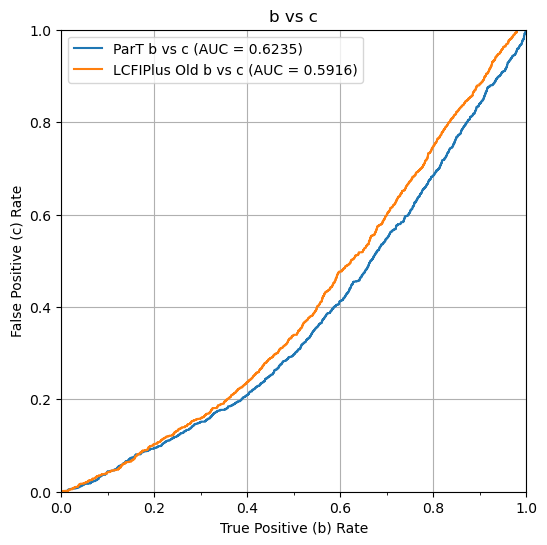

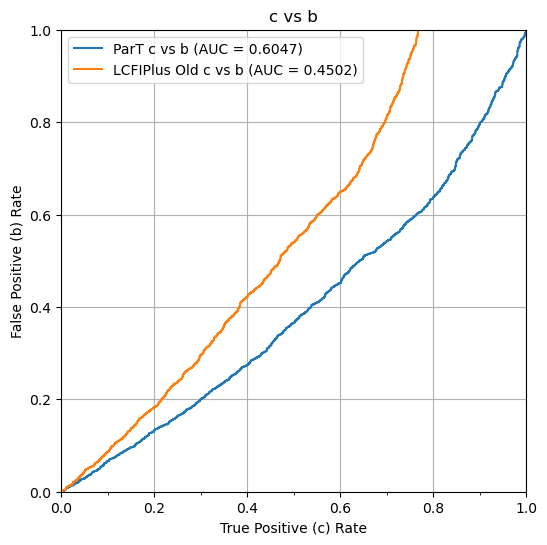

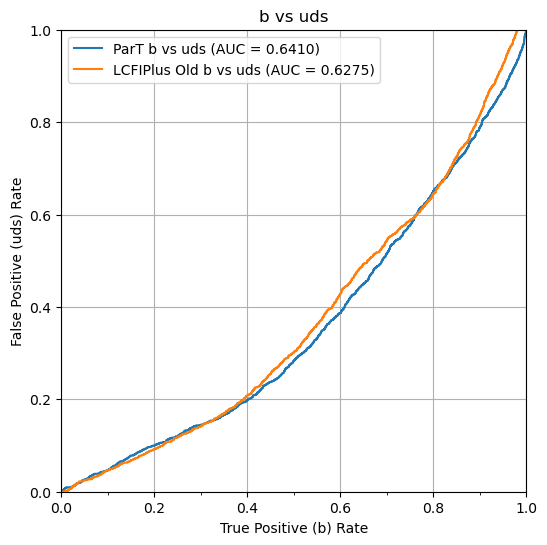

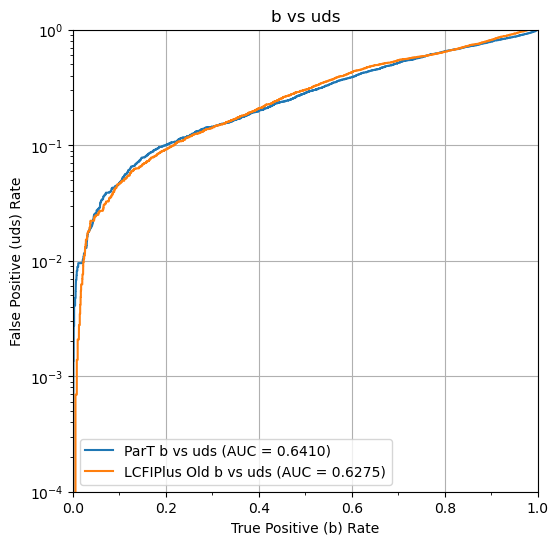

In [10]:
plot_roc_two_cases(y_true, [tags1, tags2], ['ParT', 'LCFIPlus Old'],
                   to_plot = [('b', 'c'), ('c', 'b'), ('b', 'uds'), ('b', 'uds')],
                   plot_options={
                       3: { 'yscale': 'log', 'ymin': 1.E-4 }
                       })[0]

In [ ]:
np.savez('/afs/desy.de/group/flc/pool/bliewert/MarlinWorkdirs/ZHH/other/FTag/4_testing_zzh/preds_marlin_zzh.npz',
         y_true=y_true,
         tagsPNet=tagsPNet,
         tagsLCFI=tagsLCFI,
         valid_jets_mask=valid_jets_mask)

In [11]:
tagsPNet.shape

(163488, 4)

In [ ]:
(tags_LCFI.sum(axis=1) == 0).sum()

27

In [12]:
ff = ur.open(filesFinalStates[0])

In [30]:
pdgs = np.array(ff['FinalStates']['final_state_counts.first'].array(entry_stop=1))[0]
pdgs

array([ 1,  2,  3,  4,  5,  6, 11, 12, 13, 14, 15, 16, 21, 22, 23, 24, 25],
      dtype=int32)

In [37]:
np.where(pdgs == 2)[0]

array([1])

In [16]:
ff['FinalStates'].keys()

['run',
 'event',
 'error_code',
 'final_states',
 'final_state_counts',
 'final_state_counts/final_state_counts.first',
 'final_state_counts/final_state_counts.second',
 'process',
 'event_category',
 'event_category_zhh',
 'n_fermion',
 'n_higgs',
 'n_b_from_higgs',
 'n_c_from_higgs',
 'passed']

In [6]:
length

4200

In [9]:
fs_counts[fs_passed_mask]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 2, 0],
       [0, 2, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 2, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [10]:
truth_label = np.abs(np.array(af['Jets']['TrueJetInitialElementonPDG'].array()))
truth_label

array([5, 5, 4, ..., 4, 4, 4], dtype=int32)

In [11]:
np.unique(truth_label, return_counts=True)

(array([ 1,  2,  3,  4,  5, 99], dtype=int32),
 array([  86,   94,  124, 2329, 1567,  400]))

In [29]:
af['JetTaggingComparison']['tags1'].array()

<Array [[0.998, 0.00139, ..., 0.000102], ..., [...]] type='4 * var * float32'>

In [30]:
af['JetTaggingComparison']['tags2'].array()

<Array [[0.999, 0.000418, 0.000153], ..., [...]] type='4 * var * float32'>

In [6]:
def get_tot_length(paths:list[str])->int:
    result = 0
    for path in paths:
        with ur.open(path) as rf:
            result += len(rf['JetTaggingComparison']['event'].array())
    
    return result

def parse_file(path:str):    
    with ur.open(path) as uf:
        comparison = uf['JetTaggingComparison']
        
        event_nr = np.array(comparison['event'].array(), dtype=int)
        
        tot_length = len(event_nr)

        # get the tags
        tagsPNet_raw = np.array(comparison['tags1'].array()).squeeze()

        tagsLCFI = np.array(comparison['tags2'].array()).squeeze()
        tagsPNet = np.zeros(tagsLCFI.shape)
        tagsPNet[:, [0,1,2]] = tagsPNet_raw[:, [0,1,2]]
        tagsPNet[:, 2] += tagsPNet_raw[:, 3]

        print('pre check', len(tagsPNet), tagsPNet.sum(), tagsLCFI.sum())
        
        tot_length = len(tagsPNet)
        y_true = np.zeros(tot_length)
    
        return tot_length, y_true, tagsLCFI

# TODO: # sort out invalid predictions
# some rows in LCFIPlus are zero; TODO: Why?
#        mask_invalid = tagsLCFI.sum(axis=1) == 0

In [7]:
for file in files:
    tot_length, tagsPNet, tagsLCFI = parse_file(file)

pre check 4 3.999999834195478 4.0


In [8]:
rf = ur.open(file)

In [14]:
rf['Jets'].keys()

['JetEnergy',
 'JetPt',
 'JetMomentum',
 'JetTheta',
 'JetPhi',
 'JetRapidity',
 'NCharged',
 'NNeutral',
 'NSecondaryVertices',
 'NPseudoVertices',
 'D0bprob',
 'D0cprob',
 'D0qprob',
 'Z0bprob',
 'Z0cprob',
 'Z0qprob',
 'TrkMass',
 'JetIndex',
 'Event',
 'Run',
 'TrueJetInitialElementonPDG',
 'TrueJetFinalElementonPDG',
 'TrueJetType']

In [15]:
np.array(rf['Jets']['TrueJetType'].array())

array([301,   1,   1,   1], dtype=int32)

In [17]:
np.array(rf['Jets']['TrueJetFinalElementonPDG'].array())

array([ 1, -5,  4,  4], dtype=int32)